# Generate attributes of bounding boxes from detection

In [2]:
# 在ego-hand数据集上训练得到了训练4迭代期的权重：yolov3-egohand-epoch4.pt，其在valid set做评估效果达到了0.848mAP，暂时可用来做生成bbox位置信息和分类标签的模型雏形

In [1]:
%pwd
%cd yolov3/

f:\PROJECT\project-diary\yolov3


In [ ]:
# 首先看一下需要提取bbox的图片

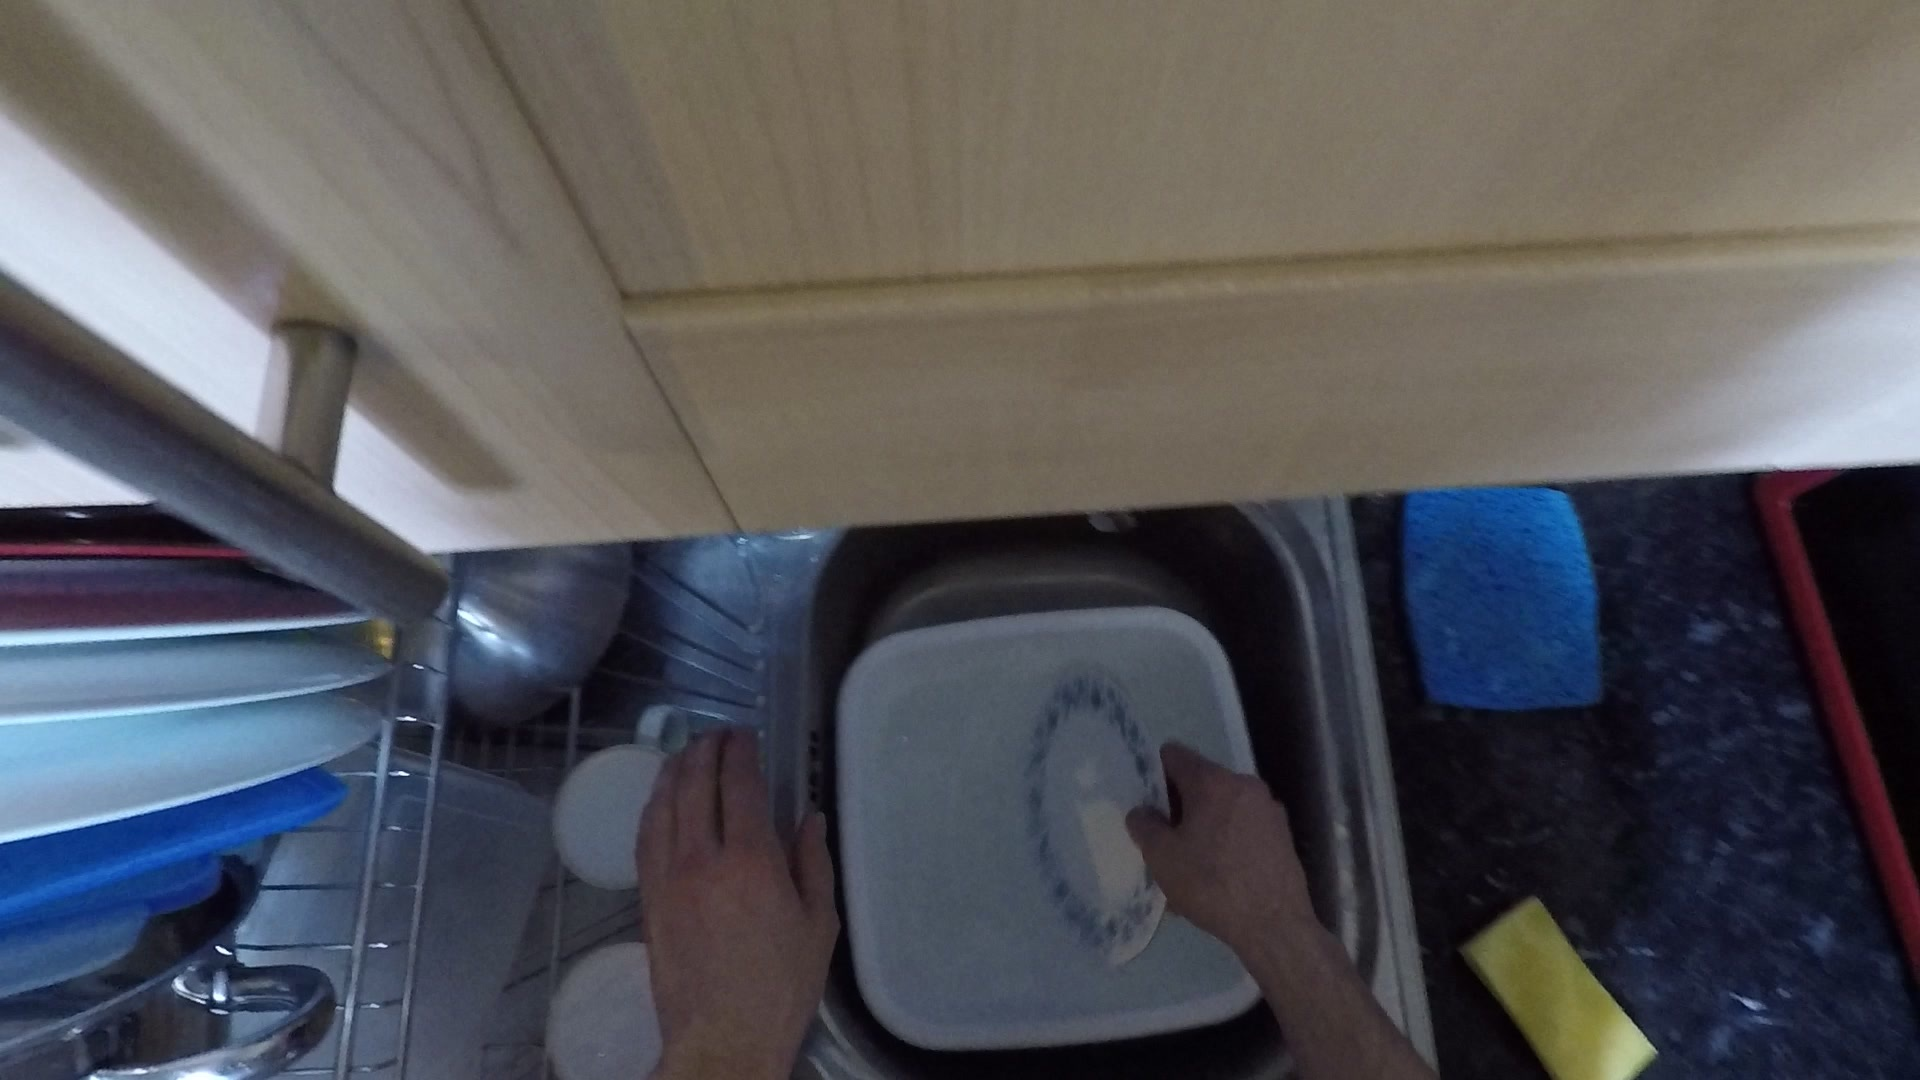

In [4]:
DEMO_IMAGE = "data/samples/0000004831.jpg"

from IPython.display import Image
Image(filename=DEMO_IMAGE)

In [48]:
!python detect.py --cfg cfg/yolov3-hand-anchors.cfg --names data/ego-hand.names --source data/samples/0000004831.jpg --output output/demo --weights weights/yolov3-egohand-epoch4.pt --save-txt

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-hand-anchors.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ego-hand.names', output='output/demo', save_txt=True, source='data/samples/0000004831.jpg', view_img=False, weights='weights/yolov3-egohand-epoch4.pt')
Using CPU

Model Summary: 222 layers, 6.15237e+07 parameters, 6.15237e+07 gradients
image 1/1 data\samples\0000004831.jpg: 320x512 2 hands, Done. (2.120s)
Results saved to f:\PROJECT\project-diary\yolov3\output/demo
Done. (2.441s)


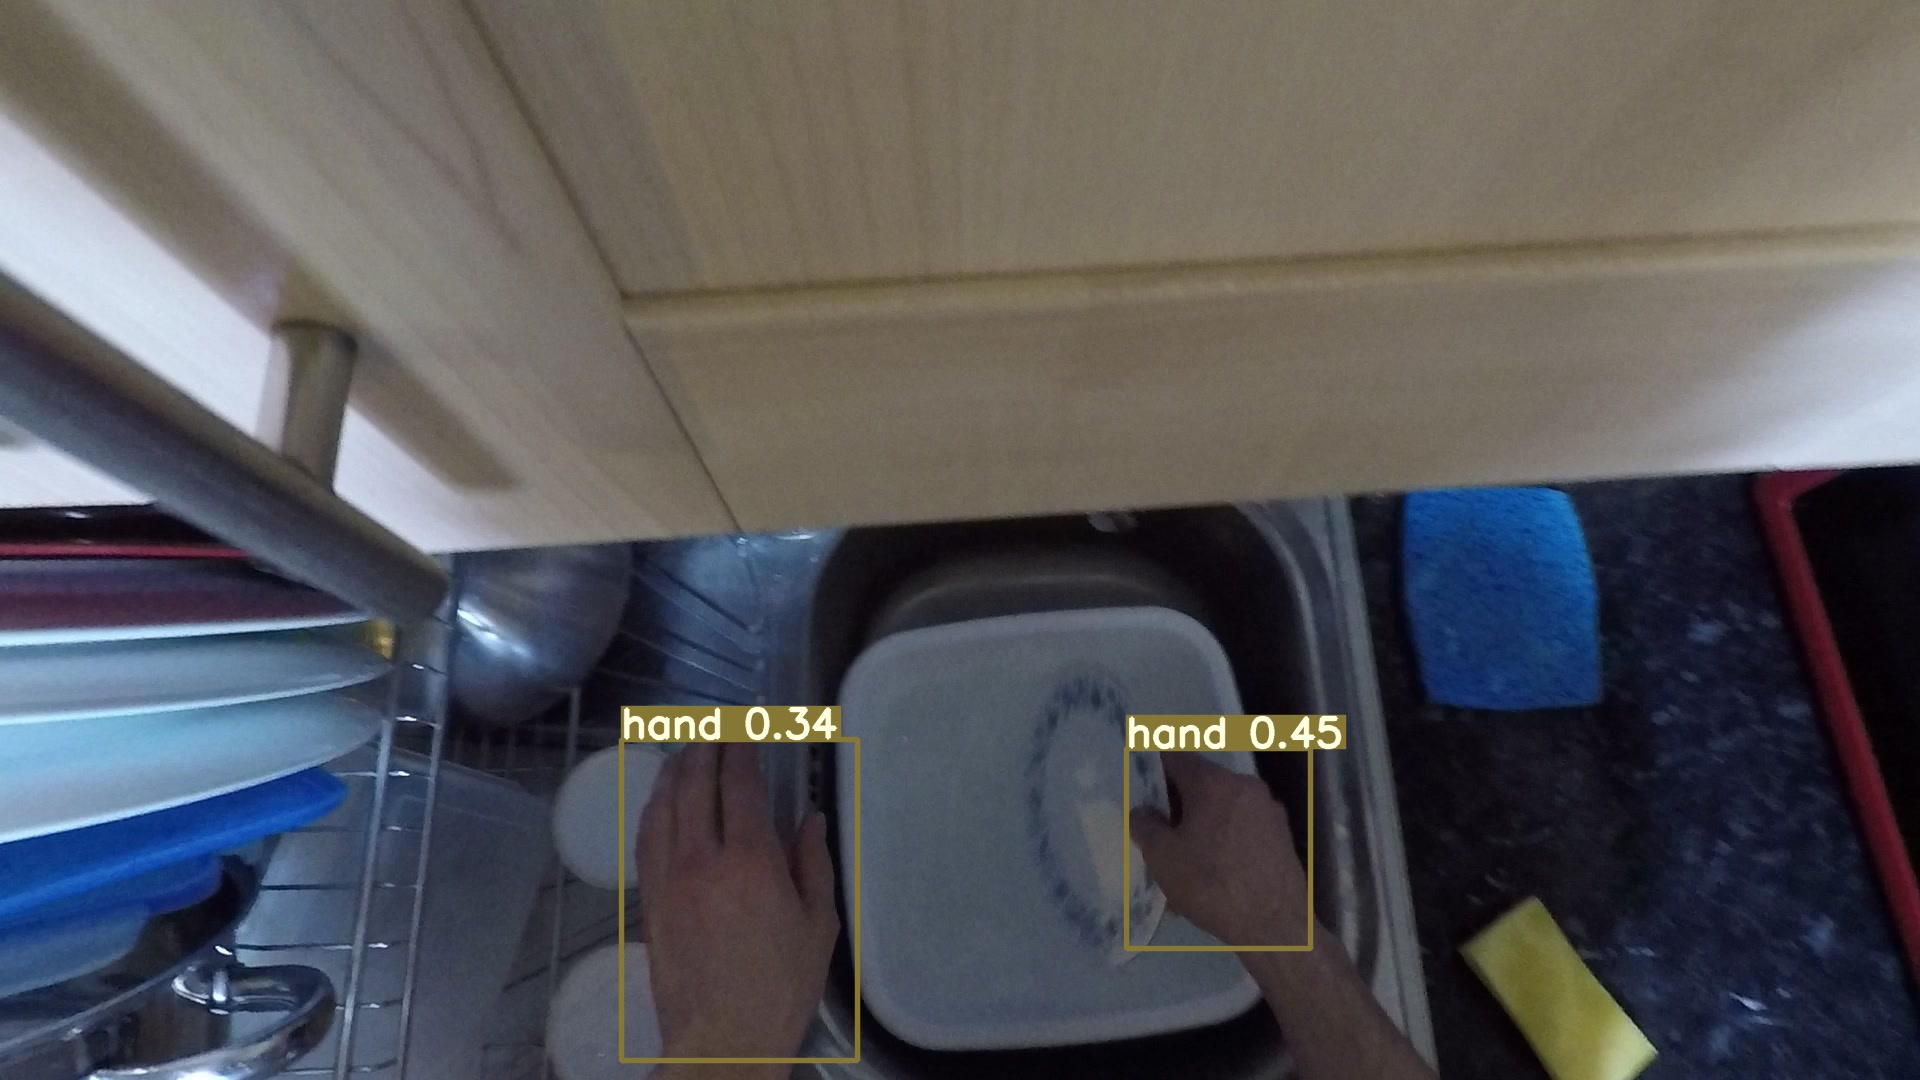

In [14]:
Image(filename="output/demo/0000004831.jpg")

In [52]:
# 使用--save-txt选项，把检测信息提取出来，结果保存在输出图片同一个路径
# 从detect.py lin 128知保存格式是：

In [ ]:
# <imagename>.txt
# cls, xcenter, ycenter, w, h

In [51]:
with open("output/demo/0000004831.txt", 'r') as f:
    for line in f:
        line = line[:-1].split()    # Strip '\n'
        line[0] = int(line[0])
        line[1:] = [float(i) for i in line[1:]]
        print(line)

[0, 0.634375, 0.785185, 0.0958333, 0.185185]
[0, 0.384896, 0.83287, 0.122917, 0.297222]


In [53]:
# <imagename>_unnorm.txt
# cls, left-top-x, left-top-y, right-bot-x, right-bot-y

In [5]:
bboxes_unnorm = []

with open("output/demo/0000004831_unnorm.txt", 'r') as f:
    for line in f:
        line = line[:-1].split()    # Strip '\n'
        line[:] = [int(i) for i in line[:]]
        bboxes_unnorm.append(line)
        print(line)

[0, 1126, 748, 1310, 948]
[0, 621, 739, 857, 1060]


In [66]:
bboxes_unnorm

[[0, 1126, 748, 1310, 948], [0, 621, 739, 857, 1060]]

In [9]:
# 裁剪出bbox的一块图片
import cv2
import os 
import shutil

def crop_bbox(img_path, bboxes, save_path):
    if os.path.exists(save_path):
        shutil.rmtree(save_path)  # delete output folder
    os.makedirs(save_path)  # make new output folder
    
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    bboxes_path = []

    for i, bbox in enumerate(bboxes):
        xyxy = bbox[1:]
        crop_img = img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
        save_name = os.path.join(save_path, img_name[:-4] + '_{}.jpg'.format(i))
        cv2.imwrite(save_name, crop_img)
        bboxes_path.append(save_name)

    return bboxes_path

In [10]:
bboxes_paths = crop_bbox(DEMO_IMAGE, bboxes_unnorm, 'output/demo/bboxes')

In [ ]:
# 显示，白色边缘是显示问题

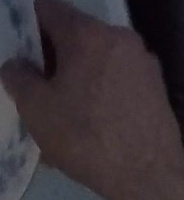

In [11]:
Image(filename=bboxes_paths[0], width=600)

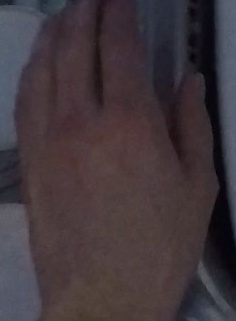

In [12]:
Image(filename=bboxes_paths[1])

---

In [ ]:
# 下面用P30训练的左右手的模型来粗略预测一下

In [13]:
!python detect.py --cfg cfg/yolov3-spp-P30.cfg --names data/P30.names --source output/demo/bboxes/ --output output/demo/diff --weights weights/yolov3-spp-P30.pt --save-txt

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-spp-P30.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/P30.names', output='output/demo/diff', save_txt=True, source='output/demo/bboxes/', view_img=False, weights='weights/yolov3-spp-P30.pt')
Using CPU

Model Summary: 225 layers, 6.25787e+07 parameters, 6.25787e+07 gradients
image 1/2 output\demo\bboxes\0000004831_0.jpg: 512x512 Done. (3.314s)
image 2/2 output\demo\bboxes\0000004831_1.jpg: 512x384 Done. (2.491s)
Results saved to f:\PROJECT\project-diary\yolov3\output/demo/diff
Done. (5.829s)


In [15]:
# 结果是P30训练出来的模型并没有对bbox对进一步的区分，这个适合检测任务的模型不太适合做分类，还要继续思考。